# An example of a single point inversion

We are going to demonstrate how we can extract a single point among all data points and do the inversion for. Firstly, we need to import required libraries:

In [1]:
#%% import liberaries
import numpy as np
import utm
import geopandas as gpd
import pygimli as pg
from pygimli.frameworks import Modelling, Inversion
from pygimli.viewer.mpl import drawModel1D
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

We want to work on the data of Trebbin Wertheim farm for instance.

In [2]:
#%% Reading data
filepath = 'TRB_Wertheim_Geophilus_roh_221125.csv'
farmName = 'Trebbin Wertheim'

EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Rho6, Gamma, BFI, IfdNr, Date, time    \
    = np.genfromtxt(filepath, skip_header=1, delimiter=';', unpack=True)
dataRaw = np.genfromtxt(filepath, names=True, delimiter=';')

 The geographic coordinates system of our data are in Decimal degrees and we need to convert them to UTM.

In [3]:
Eutm, Nutm, zone, letter  = utm.from_latlon(NdecDeg, EdecDeg) 
data = np.column_stack((Eutm, Nutm, H, Rho1, Rho2, Rho3, Rho4, Rho6, Gamma,))

Secondly, we define our Forward Operator and response function

In [4]:
"""VES inversion."""

class VESRhoModelling(Modelling):
    """Vertical electrical sounding (VES) modelling with fixed layers."""

    def __init__(self, thk, **kwargs):
        super().__init__()
        self.fwd = pg.core.DC1dRhoModelling(thk, **kwargs) # kwargs: am, bm, an, bn
        
        mesh = pg.meshtools.createMesh1D(len(thk)+1)
        # self.clearRegionProperties()
        self.setMesh(mesh)

    def response(self, par):
        """Forward response."""
        return self.fwd.response(par)

Then we need to define ABMN, thickness and number of layers:

In [5]:
amVec = np.arange(1, 6) * 0.6  # Geophilius 3.0 (2020)
b = 1.0
bmVec = np.sqrt(amVec**2+b**2)

# model space
thk = np.ones(15) * 0.1
nLayer = len(thk) + 1

Now we would like to initialize the DC Forward Modelling Operator and define our error model:

In [7]:
fop = VESRhoModelling(thk, am=amVec, an=bmVec, bm=bmVec, bn=amVec)
refPoints = pd.read_csv(f'{farmName} farm_refPoints.csv', delimiter=';')

error = np.ones_like(amVec) * 0.03 # used in inversion

Now it is time to select one data point among others and do the inversion for:

17/04/23 - 00:09:36 - pyGIMLi - INFO - Found image file: DOP383476,5781763,384879,5782403.jpg
17/04/23 - 00:09:36 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.VESRhoModelling object at 0x000001C2CBB8C720>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001C2CC8A36A0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001C2CC8F1400>
min/max (data): 49.89/56.56
min/max (error): 3%/3%
min/max (start model): 300/300
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 2289.56 (dPhi = 90.55%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 123.32 (dPhi = 94.6%) lam: 18.0
--------------------------------------------------------------------------------
inv.iter 3 ... 

17/04/23 - 00:09:36 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


chi² = 2.6 (dPhi = 97.77%) lam: 16.2
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.5 (dPhi = 40.98%) lam: 14.58
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.48 (dPhi = 0.85%) lam: 13.122
################################################################################
#                 Abort criteria reached: dPhi = 0.85 (< 2.0%)                 #
################################################################################


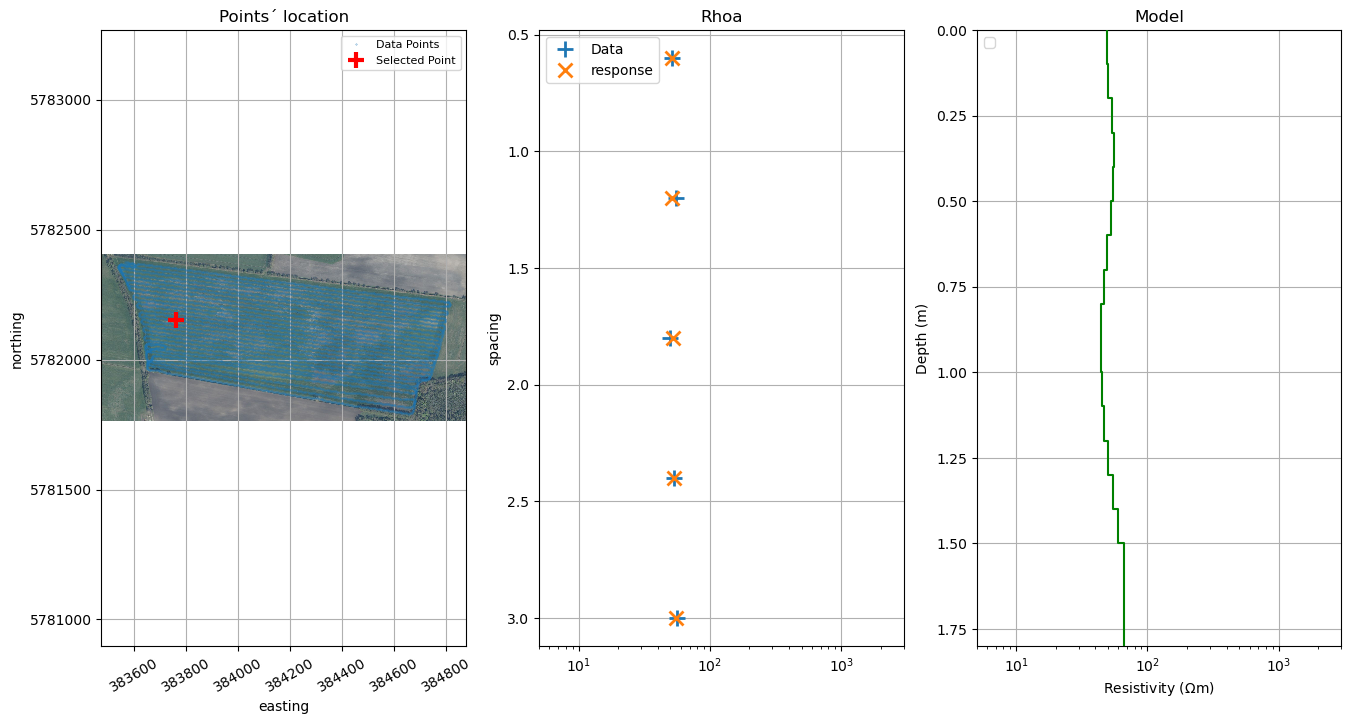

In [10]:
data_in = 5000  # We select one sounding out of our data points
data_index = int(data_in)

with PdfPages(f'{farmName} Inversion_Result_ point {data_index}.pdf') as pdf:
    fig = plt.figure(figsize=(16, 8))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
    spec = mpl.gridspec.GridSpec(ncols=3, nrows=1)
    ax0 = fig.add_subplot(spec[0,0])
    ax1 = fig.add_subplot(spec[0,1])
    ax2 = fig.add_subplot(spec[0,2])
    mydata = data[data_index][3:8]   

    ax0.plot(Eutm, Nutm, ".", markersize=0.5, label='Data Points')
    ax0.plot(data[data_index][0], data[data_index][1], "+", color='r', markersize=12, mew=3, label='Selected Point')
    pg.viewer.mpl.underlayBKGMap(ax0, mode='DOP', utmzone=33, epsg=0, uuid='8102b4d5-7fdb-a6a0-d710-890a1caab5c3', usetls=False, origin=None) 
    ax0.axis("equal")
    ax0.set_title('Points´ location')
    ax0.legend(prop={'size': 8})
    ax0.set_xlabel('easting')
    ax0.set_ylabel('northing')
    from matplotlib.ticker import FormatStrFormatter
    ax0.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax0.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax0.xaxis.set_tick_params(rotation=30)
    ax0.grid()


    Rho = mydata 

    inv = Inversion(fop=fop) # passing the fwd operator in the inversion
    inv.setRegularization(cType=1) # cType=0:MarquardtLevenberg damping, 10:mixe M.L. & smoothness Constraint
    modelMean = inv.run(Rho, error, lam=20, lambdaFactor=0.9, startModel=300, verbose=True) # stating model 100 ohm.m, lam: regularization
   
    ax1.semilogx(Rho, amVec, "+", markersize=11, mew=2, label="Data")
    ax1.semilogx(inv.response.array(), amVec, "x", mew=2, markersize=10, label="response")
    ax1.invert_yaxis()
    ax1.set_xlim([5, 3000])
    ax1.grid(True) 
    ax1.legend(fontsize=10, loc=2)
    ax1.set_ylabel('spacing')
    ax1.set_title('Rhoa')

    
    drawModel1D(ax2, thickness=thk, values=modelMean, plot='semilogx', color='g', zorder=20)
    ax2.set_xlim([5, 3000])
    ax2.legend(fontsize=10, loc=2)
    ax2.set_title('Model')

    plt.savefig(pdf, format='pdf') 
